Author : Akash Kharita (ak287@uw.edu)

In [71]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope



import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from datetime import timedelta
import os
import sys
sys.path.append('../src')


from utils import apply_cosine_taper, butterworth_filter, resample_array

import pickle
from zenodo_get import zenodo_get

import sys
sys.path.append('../deep_learning/scripts')
from neural_network_architectures import QuakeXNet_2d
import torch
import torch.nn.functional as F

## Defining some custom functions

In [2]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

## Downloading the IRIS ESEC Catalog

In [3]:
pd.set_option('display.max_columns', None)
cat_all = pd.read_csv('../data/IRISExoticEventCatalog.txt', sep='|')
cat = cat_all.copy()
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

## Each event in this is identified by a unique Event ID

In [4]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

## Extracting Manual Features

In [5]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

## Computing the duration of each event

In [6]:
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

## Loading the data 

We have a waveforms corresponding to the event ids stored in directory. These waveforms were downloaded at (P - 70, P+110) [180s]

In [115]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in range(len(event_ids)):
    try:
        files = glob("../data/iris_esec_waveforms/IRIS_ESEC/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type = 'linear')
            d = tr[0].resample(100).data
            
            ## We are going to test the ml_40 model (so we will use P-10, P+30)
            data = d[8500:12500]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 5:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

## Machine Learning model testing on ESEC events

## 1. Processing the downloaded data for feature extraction

In [116]:
st_array = np.stack(st_data)
tapered_ex = apply_cosine_taper(st_array, taper_percent = 10) 
filtered_ex = np.array(butterworth_filter(tapered_ex, 0.5, 15, 100, 4, 'bandpass'))
orig_sr = 100
new_sr = 50
normalized_data = filtered_ex / np.max(abs(filtered_ex), axis=1)[:, np.newaxis]
resampled_data = np.array([resample_array(arr, orig_sr, new_sr) for arr in normalized_data])

## 2. Extracting physical features

In [118]:
code_sttime = time.time()
features_ex_physical = pd.DataFrame([])

for i in tqdm(range(len(resampled_data))):
    try: 
        df = seis_feature.FeatureCalculator(resampled_data[i], fs  = new_sr).compute_features()
        df['serial_no'] = i
        df['event_id'] = evids[i]
        df['trace_id'] = trids[i]
        df['hod'] = hod_trace[i]
        df['dow'] = dow_trace[i]
        df['moy'] = moy_trace[i]
        df['event_type'] = event_types[i]
        df['event_subtype'] = event_subtypes[i]
        df['duration'] = event_duration[i]
        features_ex_physical = pd.concat([features_ex_physical, df])
    except:
        pass
    
print(time.time() - code_sttime)

  0%|          | 0/193 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:159: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
100%|██████████| 193/193 [00:02<00:00, 74.11it/s]

2.6154329776763916


## 3. Downloading the trained random forest model (Ml 40)

In [119]:
from zenodo_get import zenodo_get
doi = '10.5281/zenodo.13334838'
files = zenodo_get([doi])

Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13334838
Total size: 787.9 MB

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB

Checksum is correct. (7398572baf267d603e53e0203340cc8f)

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB

Checksum is correct. (cb4201470bac8fc1a7c19a20775ef95c)

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB

Checksum is correct. (5978efd4b65ea406248f2bbb5db66e2f)

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 MB

Checksum is correct. (491182443ae7eb720ba981e80f209323)

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_top_20_P_10_30_F_05_15_50.joblib   size: 

## 4. Loading the trained model

In [120]:
from joblib import dump, load

filename = 'P_10_30_F_05_15_50'
model = load('best_rf_model_all_features_phy_man_'+filename+'.joblib')
scaler_params = pd.read_csv('scaler_params_phy_man_'+filename+'.csv')


## 5. Cleaning the repository

In [121]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)   


## 6. Preparing the features

In [122]:
features_new = features_ex_physical.copy()  #[features_ex_physical['event_subtype'] == 'Rock/ice/debris avalanches and slides']
features_new = features_new.reset_index(drop = True)

## creating a features only dataframe
features_df = features_new.loc[:,scaler_params['Feature'].values]

# standardizing the features
for feature in scaler_params['Feature'].values:
    features_df[feature] = (features_df[feature] - scaler_params[scaler_params['Feature'] == feature]['Mean'].values[0]) / scaler_params[scaler_params['Feature'] == feature]['Std Dev'].values[0]

## adding manual features 
features_df['hod'] = features_new['hod']
features_df['dow'] = features_new['dow']
features_df['moy'] = features_new['moy']



## 7. Applying the model

In [123]:
results = model.predict(features_df)
probs = model.predict_proba(features_df)

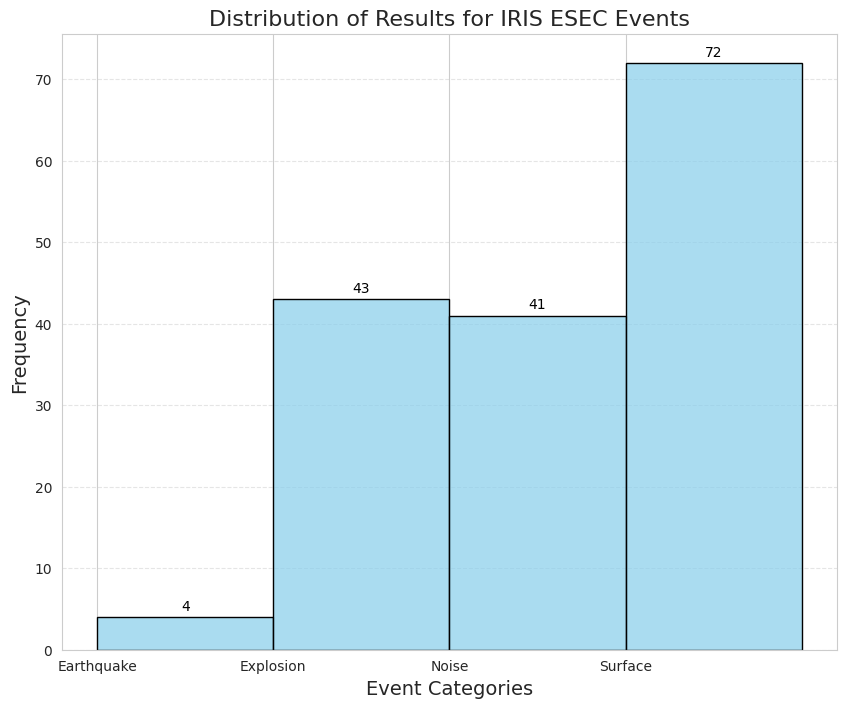

In [124]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(results, bins=range(5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Results for IRIS ESEC Events', fontsize=16)
plt.xlabel('Event Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(4), labels=['Earthquake', 'Explosion', 'Noise', 'Surface'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding annotations with the number of events in each bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [126]:
features_new['eq_probs']  = probs[:,0]
features_new['px_probs']  = probs[:,1]
features_new['no_probs']  = probs[:,2]
features_new['su_probs']  = probs[:,3]

grouped_features = features_new.groupby('event_id').mean().loc[:,['eq_probs', 'px_probs', 'no_probs', 'su_probs']]
max_probs = grouped_features.max(axis=1)
argmax_probs = grouped_features.apply(lambda row: np.argmax(row.values), axis=1)


grouped_features['max_probs'] = max_probs
grouped_features['labels'] = argmax_probs

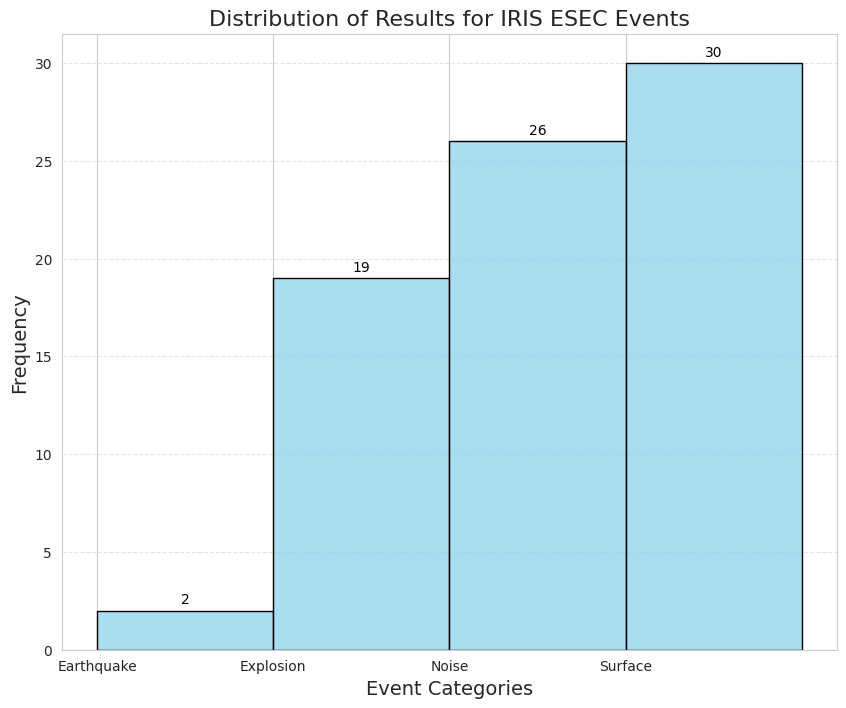

In [128]:
plt.figure(figsize=(10, 8))
ax = sns.histplot(argmax_probs, bins=range(5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Results for IRIS ESEC Events', fontsize=16)
plt.xlabel('Event Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(4), labels=['Earthquake', 'Explosion', 'Noise', 'Surface'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding annotations with the number of events in each bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

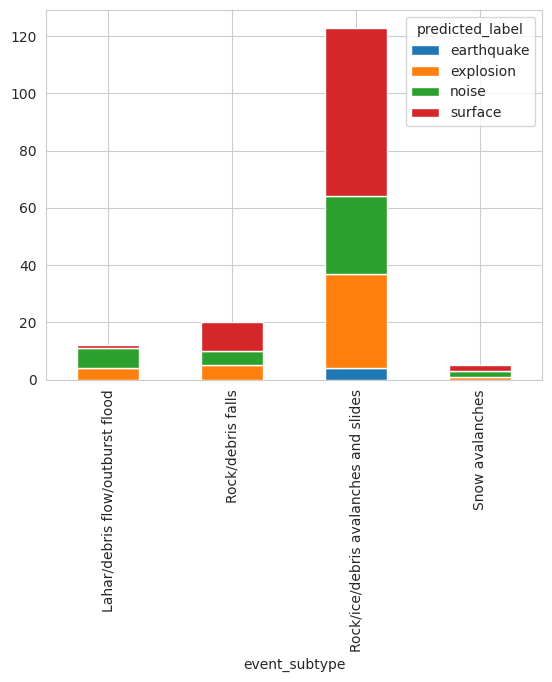

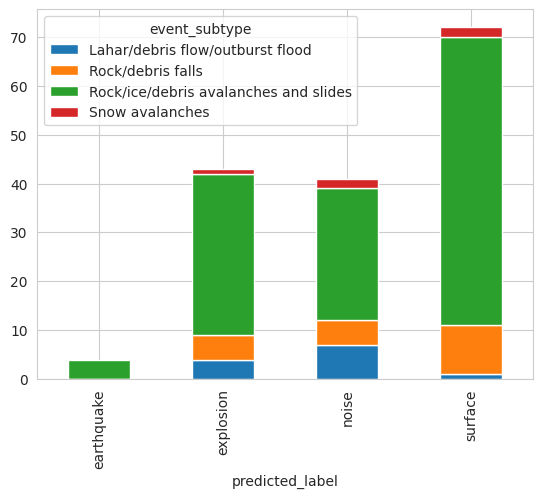

In [129]:
classes = ['earthquake', 'explosion', 'noise', 'surface']
features_ex_physical['predicted_label'] = [classes[results[i]] for i in range(len(results))]

# Assuming 'predicted_class' is the column with predicted classes
grouped = features_ex_physical.groupby(['event_subtype', 'predicted_label']).size().unstack()

# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()



# Assuming 'predicted_class' is the column with predicted classes
grouped = features_ex_physical.groupby(['predicted_label', 'event_subtype']).size().unstack()

# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()

# Deep Learning model testing on ESEC events


Here we are going to classify the exotic events present in the exotic event catalog using our deep learning model (QuakeXNet 2D)

## 1. Loading the trained model

In [72]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = "cpu"



model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('../deep_learning/trained_models/best_model_QuakeXNet_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)
model_quakexnet_2d.to(device)
model_quakexnet_2d.eval()


model = model_quakexnet_2d
model.to('cpu')


/tmp/ipykernel_1968602/1080709259.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_quakexnet_2d = torch.load('../deep_learning/trained_models/best_model_Quak

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

## 2. Preparing the input for deep learning model (QuakeXNet 2D)

This model takes 2D spectrogram as a input, this spectrogram should be extracted from a three component station

In [51]:
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []

for i in range(len(event_ids)):
    try:
        # Find all three-component waveforms for this event
        files = glob(f"../data/iris_esec_waveforms/IRIS_ESEC/waveforms/{event_ids[i]}/*H*")
        
        # Dictionary to group traces by station
        station_data = {}

        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type='linear')
            d = tr[0].resample(50).data
            data = d[3000:8000]  # Extract P-10 to P+30 (assuming 50 Hz sampling)
            snr = np.nanmax(abs(data)) / np.nanmean(abs(data))

            if snr > 5:
                station = tr[0].stats.station
                channel = tr[0].stats.channel
                key = (event_ids[i], station)  # Group by event and station
                
                if key not in station_data:
                    station_data[key] = {}

                station_data[key][channel] = data  # Store by channel

        # Process each station
        for key, traces in station_data.items():
            if len(traces) == 3:  # Ensure three-component data exists
                sorted_channels = sorted(traces.keys())  # Ensure order is consistent
                stacked_data = np.stack([traces[ch] for ch in sorted_channels])  # Shape (3, 4000)

                st_data.append(stacked_data)  # Append in shape (3, 4000)
                evids.append(key[0])  # Event ID
                trids.append(key[1])  # Station ID
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])

    except Exception as e:
        print(f"Error processing event {event_ids[i]}: {e}")
        continue

# Convert to NumPy array
st_data = np.array(st_data)  # Final shape: (num_events, 3, 4000)


In [55]:
print(st_data.shape)

(194, 3, 5000)


## 3. processing the input data

In [73]:
taper_alpha = 0.1
lowcut = 1
highcut = 20
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients
taper_alpha = 0.1
fs = 50


def extract_spectrograms(waveforms = [], fs = 50, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)  # Calculate overlap

    # Example of how to get the shape of one spectrogram
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

    # Initialize an array of zeros with the shape: (number of waveforms, channels, frequencies, time_segments)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in range(waveforms.shape[0]):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs)
            spectrograms[i, j] = Sxx  # Fill the pre-initialized array

    return spectrograms


tapered_data = np.array([np.multiply(signal.windows.tukey(st_data.shape[-1], alpha=taper_alpha), row) for row in st_data])
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])
norm = np.std(abs(filtered_data), axis=2)
normalized_data = (filtered_data / norm[:, :, None])
specs = extract_spectrograms(normalized_data)

## 4. Classifying the input data

In [74]:
# Run classification
with torch.no_grad():
    output = model(torch.Tensor(specs))
    softmax_probs = F.softmax(output, dim=1).cpu().numpy()

In [91]:
labels = np.array(['earthquake', 'explosion', 'noise','surface event'])
predictions = np.argmax(softmax_probs,axis = 1)
pred_labels = labels[predictions]

## 5. Plotting station wise results

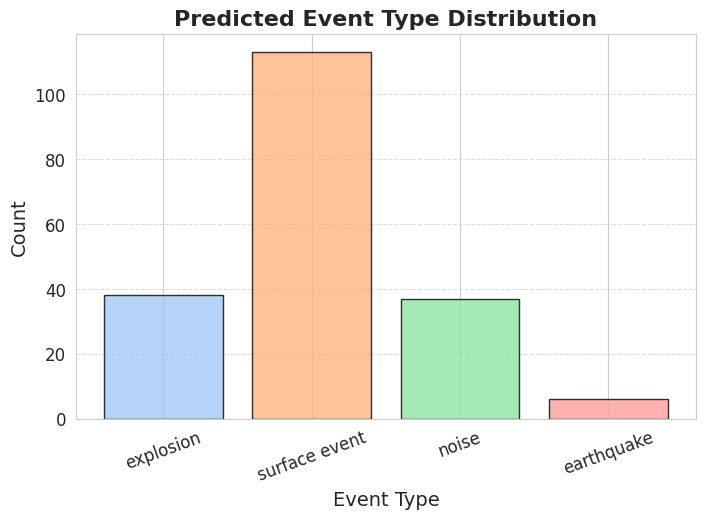

In [92]:


# Sample labels
labels = np.array(['earthquake', 'explosion', 'noise', 'surface event'])


# Count occurrences
label_counts = Counter(pred_labels)

# Use seaborn style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(8, 5))

# Define colors
colors = sns.color_palette("pastel", len(labels))

# Bar plot instead of histogram for categorical data
plt.bar(label_counts.keys(), label_counts.values(), color=colors, edgecolor="black", alpha=0.8)

# Labels & Styling
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Event Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Predicted Event Type Distribution", fontsize=16, fontweight="bold")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


## 4. Computing event wise reuslts

In [99]:
# Convert to DataFrame
df = pd.DataFrame(softmax_probs, index=evids)
# Compute mean softmax probabilities for each event ID
avg_softmax_probs = df.groupby(df.index).mean()

# Convert back to numpy arrays if needed
unique_evids = avg_softmax_probs.index.to_numpy()

# averaged_probs contains event wise probs
averaged_probs = avg_softmax_probs.to_numpy()

In [102]:
event_predictions = np.argmax(averaged_probs, axis = 1)
event_labels = labels[event_predictions]


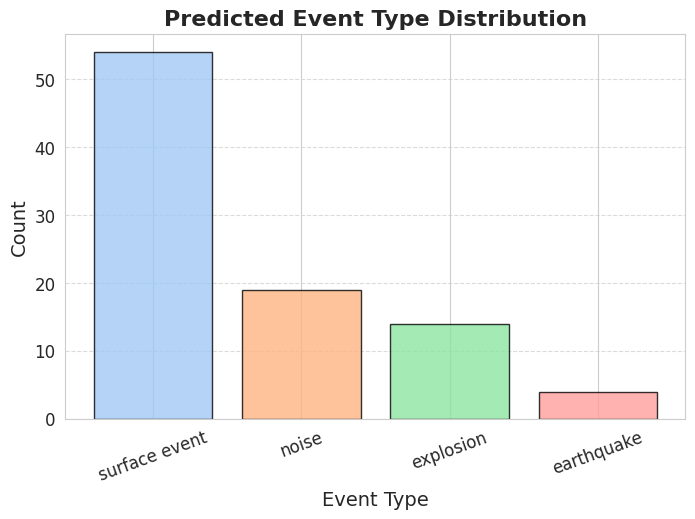

In [103]:
# Sample labels
labels = np.array(['earthquake', 'explosion', 'noise', 'surface event'])


# Count occurrences
label_counts = Counter(event_labels)

# Use seaborn style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(8, 5))

# Define colors
colors = sns.color_palette("pastel", len(labels))

# Bar plot instead of histogram for categorical data
plt.bar(label_counts.keys(), label_counts.values(), color=colors, edgecolor="black", alpha=0.8)

# Labels & Styling
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Event Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Predicted Event Type Distribution", fontsize=16, fontweight="bold")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


## 5. More analysis

In [108]:
df['event_types'] = event_types
df['event_subtypes'] = event_subtypes
df['event_duration'] = event_duration
df['predictions'] = pred_labels

,0,1,2,3,event_types,event_subtypes,event_duration,predictions
22,0.008358,0.950422,0.000582,0.040638,rock and ice avalanche,Rock/ice/debris avalanches and slides,256.0,explosion
218,0.000907,0.001024,0.000299,0.997770,landslide,Rock/ice/debris avalanches and slides,131.0,surface event
218,0.007768,0.019169,0.000325,0.972739,landslide,Rock/ice/debris avalanches and slides,131.0,surface event
218,0.025957,0.097135,0.001026,0.875882,landslide,Rock/ice/debris avalanches and slides,131.0,surface event
147,0.020779,0.029901,0.863348,0.085971,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,170.0,noise
...,...,...,...,...,...,...,...,...
176,0.001180,0.011133,0.000205,0.987483,snow avalanche,Snow avalanches,73.0,surface event
195,0.006638,0.974156,0.000088,0.019118,rock fall,Rock/debris falls,88.0,explosion
195,0.013329,0.931952,0.000150,0.054569,rock fall,Rock/debris falls,88.0,explosion
119,0.003361,0.004202,0.000446,0.991991,"rock fall, rock and ice avalanche",Rock/ice/debris avalanches and slides,104.0,surface event


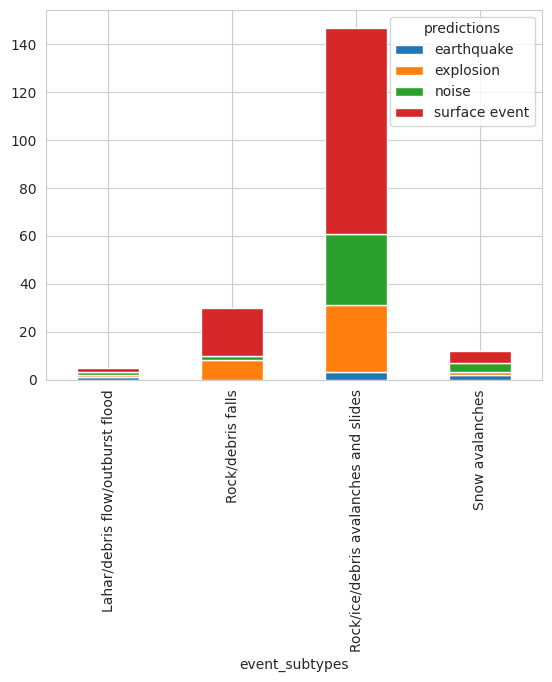

In [110]:
# Assuming 'predicted_class' is the column with predicted classes
grouped = df.groupby(['event_subtypes', 'predictions']).size().unstack()

# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()





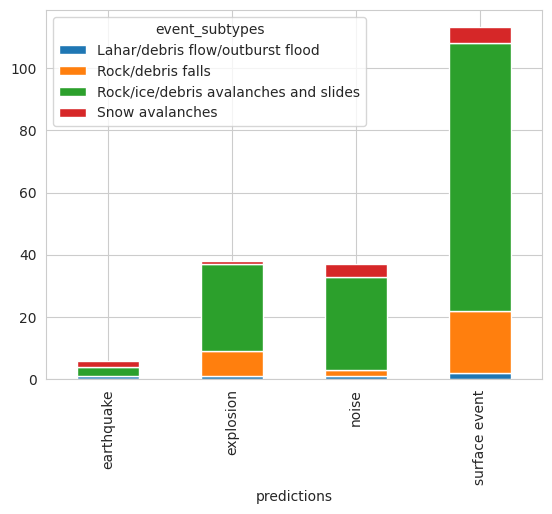

In [112]:
# Assuming 'predicted_class' is the column with predicted classes
grouped = df.groupby(['predictions', 'event_subtypes']).size().unstack()
zz
# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()